In [1]:
import os


#paths
IMAGES_PATH = "../../data/Datasets_Enhancy/datasets/"
ANNOT_PATH = "../../extra/batch/batch4" #small batch of 5000 files
#ANNOT_PATH = "../../extra/clean_export.dat"
MODEL_PATH = "../../models/bboxRegressor.h5"
PLOT_PATH = "../../Tmp/plot.png"
TEST_FILENAMES = "test_files.txt"

#hyperparameters
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 64


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
from magic import from_file
import re

TF_ENABLE_ONEDNN_OPTS=0

2022-05-20 15:00:46.628111: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-20 15:00:46.666486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 15:00:46.666525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import get_image_size as gis

In [4]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOT_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [5]:
# loop over the rows
imageAmount = int(rows[0])
print(imageAmount)
for (i, row) in enumerate(rows[1:]):
    try:
        if (i % int(imageAmount/10) == 0): print("{:.2f}% left".format(100-(i/(imageAmount/100))))
        # break the row into the filename and bounding box coordinates
        row = row.split(" ")
        filename = row[1]
        startX, startY, endX, endY = row[2], row[3], row[6], row[7]

        #Open the file
        imagePath = os.path.sep.join([IMAGES_PATH, filename])
        (w, h) = gis.get_image_size(imagePath)

        #normalize bbox
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h
        
        #print(startX, startY, endX, endY)

        #load image
        image = load_img(imagePath, target_size=(224,224))
        image = img_to_array(image)

        data.append(image)
        targets.append((startX, startY, endX, endY))
        filenames.append(filename)
    except FileNotFoundError:
        print("File {} Not Found, entry dropped.".format(filename))
    except:
        continue
print("done")

5000
100.00% left
90.00% left
80.00% left
70.00% left
60.00% left
50.00% left
40.00% left
30.00% left
20.00% left
10.00% left
done


In [6]:
#convert data to np array and [0, 1] value
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [7]:
#partition data into training test and validate
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

#unpack data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# write test filenames to see the prediction
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [8]:
#load the vgg16 network
vgg = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224,224,3)))

#freeze vgg layers
vgg.trainable=False

#flatten max pooling output
flatten = vgg.output
flatten = Flatten()(flatten)

#construct fully connected header layer to output the predicted bbox
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="relu")(bboxHead)

#Construct model
model = Model(inputs=vgg.input, outputs=bboxHead)


2022-05-20 15:01:42.520798: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nemoc/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-05-20 15:01:42.520834: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 15:01:42.520864: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nemo-lp5065mj): /proc/driver/nvidia/version does not exist
2022-05-20 15:01:42.521380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#initialize optimizer
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
#train network
print("[INFO] Training the model")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

[INFO] Training the model
Epoch 1/10
70/70 [==============================] - 1104s 16s/step - loss: 0.0214 - val_loss: 0.0117
Epoch 2/10
70/70 [==============================] - 1101s 16s/step - loss: 0.0100 - val_loss: 0.0100
Epoch 3/10
70/70 [==============================] - 556s 8s/step - loss: 0.0079 - val_loss: 0.0101
Epoch 4/10
70/70 [==============================] - 494s 7s/step - loss: 0.0067 - val_loss: 0.0095
Epoch 5/10
70/70 [==============================] - 498s 7s/step - loss: 0.0059 - val_loss: 0.0096
Epoch 6/10
70/70 [==============================] - 501s 7s/step - loss: 0.0054 - val_loss: 0.0109
Epoch 7/10
70/70 [==============================] - 495s 7s/step - loss: 0.0045 - val_loss: 0.0097
Epoch 8/10
70/70 [==============================] - 503s 7s/step - loss: 0.0040 - val_loss: 0.0093
Epoch 9/10
70/70 [==============================] - 490s 7s/step - loss: 0.0035 - val_loss: 0.0096
Epoch 10/10
70/70 [==============================] - 500s 7s/step - loss: 0.003

In [11]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving object detector model...


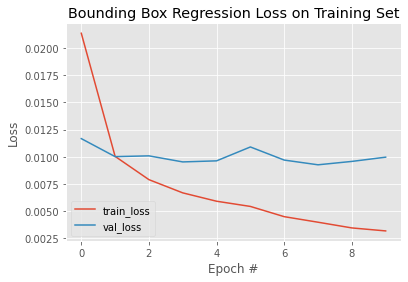

In [12]:
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)